In [1]:
import pandas as pd
df = pd.read_csv("C:/Users/CLOUDY/Desktop/工作/DATA5925/archive/the_guardian_full.csv")

In [2]:
df['Tags'] = df['Tags'].astype(str).str.lower()

In [3]:
keywords = ['russ', 'ukra', 'russia', 'ukraine', 'putin', 'zelensky', 'donbas', 'kyiv']
df['has_keyword'] = df['Tags'].apply(lambda x: any(k in x for k in keywords))
df_filtered = df[df['has_keyword']]

In [4]:
df_filtered['Time'] = pd.to_datetime(df_filtered['Time'], format='%a %d %b %Y %H.%M GMT', errors='coerce')
"""
# 第二步：设定时间范围
start_date = pd.Timestamp("2022-01-01")
end_date = pd.Timestamp("2024-12-31")

# 第三步：筛选时间在范围内的数据
df_filtered = df_filtered[(df_filtered['Time'] >= start_date) & (df_filtered['Time'] <= end_date)]
"""

C:\Users\CLOUDY\AppData\Local\Temp\ipykernel_9756\1467887492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Time'] = pd.to_datetime(df_filtered['Time'], format='%a %d %b %Y %H.%M GMT', errors='coerce')


'\n# 第二步：设定时间范围\nstart_date = pd.Timestamp("2022-01-01")\nend_date = pd.Timestamp("2024-12-31")\n\n# 第三步：筛选时间在范围内的数据\ndf_filtered = df_filtered[(df_filtered[\'Time\'] >= start_date) & (df_filtered[\'Time\'] <= end_date)]\n'

In [5]:
df_filtered

,URL,Title,Description,Content,Time,Tags,has_keyword
45,https://www.theguardian.com/world/2015/jan/13/...,Rocket attack that killed 10 civilians at Ukra...,Shellfire heard across rebel-held Donetsk afte...,An attack on a passenger bus in eastern Ukrain...,2015-01-13 23:09:00,"['ukraine', 'europe', 'news']",True
70,https://www.theguardian.com/world/2015/jan/19/...,Ukraine launches operation to reclaim lost gro...,Russia’s deputy foreign minister said operatio...,Pro-Russia separatists renewed attacks on Ukra...,2015-01-19 21:23:00,"['ukraine', 'europe', 'russia', 'vladimir puti...",True
73,https://www.theguardian.com/world/2015/jan/20/...,Ukrainian drug addicts dying due to treatment ...,United Nations envoy says those on substitutio...,As many as 100 drug users in Crimea may have d...,2015-01-20 23:00:00,"['ukraine', 'europe', 'russia', 'news']",True
120,https://www.theguardian.com/world/2015/feb/05/...,Merkel and Hollande’s surprise Moscow visit ra...,Summit announcement spawns suspicions that Put...,The leaders of Germany and France abruptly ann...,2015-02-05 23:58:00,"['ukraine', 'françois hollande', 'angela merke...",True
122,https://www.theguardian.com/world/julian-borge...,"In the US-Russian relationship, something nucl...","Four years on, both countries are sticking to ...",As US-Russian relations continue their long sl...,2015-02-05 23:27:00,"['nuclear weapons', ""julian borger's global se...",True
...,...,...,...,...,...,...,...
187372,https://www.theguardian.com/books/2023/nov/15/...,‘Hallucinate’ chosen as Cambridge dictionary’s...,The psychological verb gained an extra meaning...,Cambridge dictionary’s word of the year for 20...,NaT,"['books', 'linguistics', 'artificial intellige...",True
187481,https://www.theguardian.com/music/2023/nov/19/...,Yuri Temirkanov obituary,Russian conductor admired for his electrifying...,As head of two of Russia’s leading musical ins...,NaT,"['classical music', 'russia', 'obituaries']",True
187565,https://www.theguardian.com/tv-and-radio/2023/...,"Russell T Davies on secrets, sex and falling f...","The show was his first TV memory, his obsessio...",My first proper memory of television? I can da...,NaT,"['doctor who', 'russell t davies', 'fantasy tv...",True
187658,https://www.theguardian.com/film/2023/nov/01/s...,Scarlett Johansson takes legal action against ...,The actor’s likeness was used in an online adv...,Scarlett Johansson has taken legal action agai...,NaT,"['scarlett johansson', 'artificial intelligenc...",True


In [6]:
import openai
import time
import tiktoken  # Added for token counting
from concurrent.futures import ThreadPoolExecutor, as_completed

# 设置 DeepSeek API 地址和 Key（注意：建议将 API key 存在环境变量中，避免泄露）
openai.api_base = "https://api.deepseek.com"
openai.api_key = ""
# 初始化客户端（新版 SDK 必须使用 `OpenAI()` 实例）
client = openai.OpenAI(base_url=openai.api_base, api_key=openai.api_key)

# Token counter (assuming similar to GPT)
tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")  # Approximate for DeepSeek

def analyze_bias(i, content):
    prompt = (
        "Analyze the political bias of the following news content about the Russia–Ukraine war. "
        "You MUST respond with ONLY one exact word:\n"
        "- 'Left' (for progressive/socialist bias)\n"
        "- 'Right' (for conservative/nationalist bias)\n"
        "- 'Central' (if no clear bias or balanced view)\n\n"

        "Rules:\n"
        "1. DO NOT add explanations, notes, or punctuation.\n"
        "2. If unsure, default to 'Central'.\n\n"

        "Bias Indicators:\n"
        "- Left: supports Ukraine's sovereignty, frames Russia as aggressor, emphasizes human rights, condemns authoritarianism.\n"
        "- Right: emphasizes NATO provocation, supports Russian security concerns, criticizes Western interference, favors national sovereignty.\n"
        "- Central: neutral tone, balanced reporting, no ideological lean, includes multiple perspectives.\n\n"

        f"Content:\n{content}"
    )

    try:
        if len(tokenizer.encode(prompt)) > 9990:
            truncated = tokenizer.encode(content)[:5000]
            content = tokenizer.decode(truncated)
            prompt = prompt.replace(f"Content:\n{content}", f"Content:\n{content}")
            print(f"[⚠️ Truncated RU/UKR @ {i}]")
        
        response = client.chat.completions.create(
            model="deepseek-chat",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.0,
            max_tokens=10,
            stop=["\n", ".", ","]
        )

        result = response.choices[0].message.content.strip()
        result = (
            "Left" if "left" in result.lower() else
            "Right" if "right" in result.lower() else
            "Central"
        )
    except Exception as e:
        result = f"[ERROR] {str(e)}"
        print(f"[❌ RU/UKR Error] at {i}: {result}")
    
    return i, result

# ✅ 使用线程池并发处理
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = [executor.submit(analyze_bias, i, content) for i, content in enumerate(df_filtered["Content"])]

    for future in as_completed(futures):
        i, result = future.result()
        df_filtered.at[i, "bias"] = result
        print(f"Processed {i+1}/{len(df_filtered)}: {result}")

# ✅ 保存处理结果
df_filtered.to_csv("GUAD-RU.csv", index=False)


C:\Users\CLOUDY\AppData\Local\Temp\ipykernel_9756\208918946.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.at[i, "bias"] = result


Processed 1/4131: Neutral
Processed 3/4132: Left-wing
Processed 4/4133: Neutral
Processed 5/4134: Neutral
Processed 2/4135: Neutral
Processed 6/4136: Neutral
Processed 7/4137: Neutral
Processed 8/4138: Neutral
Processed 9/4139: Neutral
Processed 10/4140: Neutral
Processed 11/4141: Left-wing
Processed 13/4142: Neutral
Processed 12/4143: Neutral
Processed 14/4144: Neutral
Processed 15/4145: Left-wing
Processed 16/4146: Right-wing
Processed 17/4147: Left-wing
Processed 18/4148: Neutral
Processed 19/4149: Neutral
Processed 20/4150: Neutral
Processed 22/4151: Neutral
Processed 21/4152: Neutral
Processed 24/4153: Neutral
Processed 25/4154: Neutral
Processed 23/4155: Neutral
Processed 27/4156: Neutral
Processed 26/4157: Neutral
Processed 28/4158: Neutral
Processed 29/4159: Neutral
Processed 31/4160: Neutral
Processed 32/4161: Neutral
Processed 30/4162: Neutral
Processed 33/4163: Neutral
Processed 34/4164: Neutral
Processed 35/4165: Neutral
Processed 36/4166: Neutral
Processed 37/4167: Neutral

In [8]:
df_filtered.to_csv("Guad_RU.csv")

有效数据量: 4128
bias分布:
bias
Neutral       3393
Left-wing      639
Right-wing      96
Name: count, dtype: int64


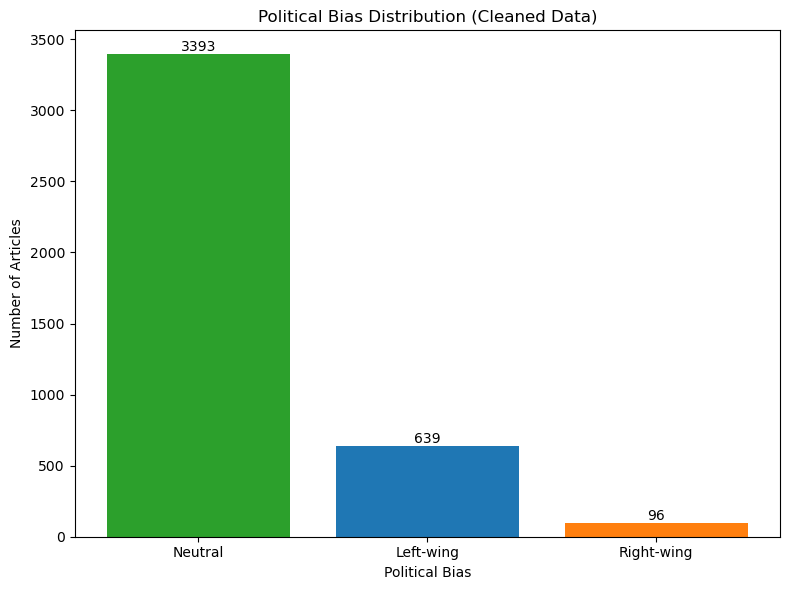

In [11]:
df=df_filtered
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.parser import parse
# 1. 定义颜色映射（只包含有效类别）
COLOR_MAPPING = {
    'Left-wing': '#1f77b4',  # 蓝色
    'Right-wing': '#ff7f0e',  # 橙色
    'Neutral': '#2ca02c'     # 绿色
}


# 清洗日期
def clean_date(date_str):
    try:
        date_part = ' '.join(date_str.split()[:4])
        return datetime.strptime(date_part, "%a %d %b %Y").strftime("%Y-%m-%d")
    except:
        return None




# 3. 清洗bias列 - 关键修复！
# 只保留预定义的三种类别，其他标记为NaN
valid_biases = list(COLOR_MAPPING.keys())
df["bias"] = df["bias"].apply(lambda x: x if x in valid_biases else None)
df = df.dropna(subset=["bias"])  # 删除无效的bias

print(f"有效数据量: {len(df)}")
print("bias分布:")
print(df["bias"].value_counts())

# 4. 绘制扇形图
bias_counts = df["bias"].value_counts()

# 4. 绘制柱状图
plt.figure(figsize=(8, 6))
bars = plt.bar(
    bias_counts.index,
    bias_counts.values,
    color=[COLOR_MAPPING[x] for x in bias_counts.index]
)

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.title("Political Bias Distribution (Cleaned Data)")
plt.xlabel("Political Bias")
plt.ylabel("Number of Articles")
plt.tight_layout()
plt.savefig("bias_bar_cleaned.png", dpi=300)
plt.show()
